In [1]:
!pip install datasets evaluate transformers[torch] accelerate>=0.20.1

In [2]:
import os
import time
from transformers import ViTForImageClassification, ViTImageProcessor, AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer, AutoTokenizer, AutoConfig, pipeline, AutoImageProcessor
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import accuracy_score
import copy
import numpy as np
from datasets import load_dataset, load_metric, Dataset, Image
from pathlib import Path
from tqdm import tqdm
import evaluate
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor)

In [3]:
# Подключение гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Путь к весам модели учителя.
path_to_teacher_model = "drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_teacher/teacher_model"

extractor_teacher = AutoFeatureExtractor.from_pretrained(path_to_teacher_model)
#vit_model_teacher = AutoModelForImageClassification.from_pretrained(path_to_teacher_model)
vit_model_teacher = ViTForImageClassification.from_pretrained(path_to_teacher_model).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
class KnowledgeDistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        self.alpha = alpha
        self.temperature = temperature

        super().__init__(*args, **kwargs)



In [7]:
class KnowledgeDistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        #Extract cross-entropy loss and logits from student
        outputs_student = model(**inputs)
        loss_ce = outputs_student.loss
        logits_student = outputs_student.logits

        # Extract logits from teacher
        outputs_teacher = self.teacher_model(**inputs)
        logits_teacher = outputs_teacher.logits

        #Computing distillation loss by Softening probabilities
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        #The reduction=batchmean argument in nn.KLDivLoss() specifies that we average the losses over the batch dimension.
        loss_kd = self.args.temperature ** 2 * loss_fct(
                F.log_softmax(logits_student / self.args.temperature, dim=-1),
                F.softmax(logits_teacher / self.args.temperature, dim=-1))

        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_student) if return_outputs else loss

In [8]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']


    return {
        "accuracy": acc_score
    }

In [9]:
def model_use(model, img):
    with torch.no_grad():
        logits = model(**img).logits

        loss = model(**img).loss

    predicted_label = logits.argmax(-1).item()

    return model.config.id2label[predicted_label]

In [10]:
batch_size = 8
processor = ViTImageProcessor.from_pretrained("drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_student/student_model", return_tensors='pt', padding=False)

student_training_args = KnowledgeDistillationTrainingArguments(
    output_dir="drive/MyDrive/Colab Notebooks/ITMO/Model_compression/student_model_after_train", evaluation_strategy = "epoch",
    num_train_epochs=1, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha= 0.5, weight_decay=0.01, remove_unused_columns=False, save_strategy='epoch', load_best_model_at_end=True, save_total_limit=1)

In [11]:
image_dict = {}


file_names = []
labels = []
for file in sorted((Path('drive/MyDrive/Colab Notebooks/ITMO/Model_compression/dataset').glob('*/*/*.jpg'))):
    file_names.append(str(file))

    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "labels": labels}).cast_column("image", Image())


1800 1800


In [13]:
print(labels)

['cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats',

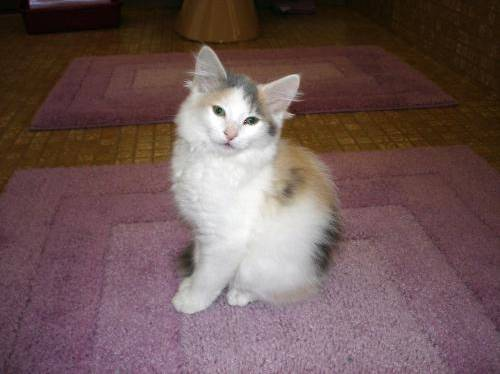

In [14]:
dataset[0]["image"]

In [12]:
labels_list = list(set(labels))
print(labels_list)
labels_list = labels_list[::-1]
print(labels_list)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

['dogs', 'cats']
['cats', 'dogs']
{0: 'cats', 1: 'dogs'} 

 {'cats': 0, 'dogs': 1}


In [13]:
dataset = dataset.train_test_split(test_size=0.1)
train_data = dataset['train']
test_data = dataset['test']

In [14]:
train_data[0]['labels']

'cats'

In [19]:
print(train_data[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x345 at 0x7895200F9EA0>, 'labels': 'cats'}


In [15]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]

    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [16]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["labels"]] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [22]:
train_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x345>,
 'labels': 'cats',
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1

In [17]:
# Путь к весам модели ученика.
path_to_student_model = "drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_student/student_model"

extractor_student = AutoFeatureExtractor.from_pretrained(path_to_student_model)

vit_model_student = ViTForImageClassification.from_pretrained(path_to_student_model, num_labels=len(labels_list), ignore_mismatched_sizes=True).to(device)

vit_model_student.config.id2label = id2label
vit_model_student.config.label2id = label2id

print(len(labels_list))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_student/student_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2


In [18]:
print(vit_model_student.config.id2label)
print(vit_model_student.config.label2id)

{0: 'cats', 1: 'dogs'}
{'cats': 0, 'dogs': 1}


In [19]:
num_labels = len(labels_list)
student_config = (AutoConfig.from_pretrained(path_to_student_model,
                                             num_labels=num_labels,
                                             id2label=id2label,
                                             label2id=label2id))



def student_init():
    #return (AutoModelForImageClassification.from_pretrained(path_to_student_model, config=student_config, ignore_mismatched_sizes=True))
    return (ViTForImageClassification.from_pretrained(path_to_student_model, config=student_config, ignore_mismatched_sizes=True).to(device))

In [20]:
vit_small_trainer = KnowledgeDistillationTrainer(model_init=student_init,
        teacher_model=vit_model_teacher, args=student_training_args,
        train_dataset=train_data, eval_dataset=test_data,
        compute_metrics=compute_metrics, data_collator= collate_fn, tokenizer=processor)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_student/student_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
vit_small_trainer.train()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at drive/MyDrive/Colab Notebooks/ITMO/Model_compression/weights_student/student_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.021836,1.000000


TrainOutput(global_step=203, training_loss=0.134407268956377, metrics={'train_runtime': 813.043, 'train_samples_per_second': 1.993, 'train_steps_per_second': 0.25, 'total_flos': 3.170085637791744e+16, 'train_loss': 0.134407268956377, 'epoch': 1.0})

In [22]:
vit_small_trainer.save_model("drive/MyDrive/Colab Notebooks/ITMO/Model_compression/student_model_after_train")

In [23]:
path_to_new_student_model = "drive/MyDrive/Colab Notebooks/ITMO/Model_compression/student_model_after_train"

vit_model_new_student = ViTForImageClassification.from_pretrained(path_to_new_student_model)

extractor_new_student = AutoFeatureExtractor.from_pretrained(path_to_new_student_model)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [24]:
# Путь к данным. 80 фото кошек и 80 фото собак.
path = "drive/MyDrive/Colab Notebooks/ITMO/Model_compression/data/"
images_list = os.listdir(path)

In [25]:
# Функция для замера размера модели.
def size_measurement(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / (1024 ** 2)
    print('model size: {:.3f}MB'.format(size_all_mb))

In [26]:
# Найдем размер исходной модели учителя google/vit-base-patch16-224-in21k.
size_measurement(vit_model_teacher)

model size: 327.302MB


In [27]:
# Найдем размер модели ученика timm/vit_small_patch16_224.augreg_in21k.
size_measurement(vit_model_new_student)

model size: 82.651MB


In [28]:
from PIL import Image

start_time = time.time()

# Собака 1, кошка 0.
target_list = []
predict_list = []

for element in images_list:

    image = Image.open(path + element, mode='r', formats=None)

    inputs_s = extractor_new_student(image, return_tensors="pt")

    predict = model_use(vit_model_new_student , inputs_s)

    target = element[:element.find(".")]

    if target == "dog":
        label = 1
    else:
        label = 0

    target_list.append(label)

    if predict == "dogs":
        pr = 1
    else:
        pr = 0

    predict_list.append(pr)

end_time = time.time()

acc = accuracy_score(target_list, predict_list)
print("Точность модели ученика после дистилляции знаний = ", acc)
print("Время обработки изображений моделью учеником после дистилляции знаний = ", end_time-start_time, " секунд")
print("Скорость обработки изображений у модели ученика после дистилляции знаний составила  ", len(images_list)/(end_time-start_time), " картинок в секунду")

Точность модели ученика после дистилляции знаний =  1.0
Время обработки изображений моделью учеником после дистилляции знаний =  46.7033314704895  секунд
Скорость обработки изображений у модели ученика после дистилляции знаний составила   3.425879802623918  картинок в секунду
